# Mushroom Harvester



**Investigating the Effectiveness of SVM for Mushroom Data**

The SVM code algorithm is derived from the Tutorial 3 example. The aim is to experiment with SVM to see what results can be observed when applied to the mushroom dataset.

In [ ]:
# Standard Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Install Quadratic Solvers
%pip install qpsolvers
import qpsolvers
from qpsolvers import solve_qp
solver = qpsolvers.available_solvers[0]
qpsolvers.available_solvers

# For Performance Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from plotly import express as px, graph_objects as go

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 1.9 MB/s eta 0:00:00


In [ ]:
# Import Github
url = 'https://raw.githubusercontent.com/Yummi305/mushroomHarvest/main/data/mushrooms.csv'

In [ ]:
# Store data (Github Version)
df = pd.read_csv(url)

# Preprocess the data (one-hot encoding)
df_clean = pd.get_dummies(df.drop(columns=['class']), df.columns[1:]).join(df['class'] == 'e')
df_clean

# Split into X and Y
X = df_clean.drop('class', axis=1)
Y = df_clean['class']

# Split into training and testing data, 20% split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
# Number of points is equal to number of rows of the dataset (and therefore length)
n_points = len(X_train)

# Changing X and Y data to array using .to_numpy()
X = df_clean.drop('class', axis=1)
x_train_data = X_train.to_numpy()
labels = y_train.to_numpy()

##### The following code is derived from Tutorial 3 Solution #####

# Inputs for calculation
n = n_points            # total number of rows of mushroom data
x = x_train_data              # data features [fins, odor, habitat]
y = labels              # class values [i.e., posionous, edible]
y = y.astype(float)
l = 1e-5                # default value
xy = x * y[:,None]
P = xy @ xy.T
q = -1*np.ones(n)
A = y[None,:]
b = np.zeros(1)
G = None
h = None
lb = np.zeros(n)
ub = (1/(2*n*l)) * np.ones(n)

# Calculation
c = solve_qp(P, q, G, h, A, b, lb, ub, solver=solver)

In [ ]:
###### The following code is from Tutorial 3 #####
w = c @ xy  # Calculating Weights

# Calculating the support vectors.
sv = (c > l)
n_support_vectors = len(sv)

# Calculate b value for each support vector
b_sv = x[sv] @ w - y[sv]

# Average to achieve a single b value
b = b_sv.mean()
print("the value of b_sv is: ", b_sv)
print("the value of b is: ", b)

the value of b_sv is:  [-3.31474367e-22 -2.28517441e-21 -1.69635835e-22 ... -3.42193904e-21
 -3.57286084e-21 -1.26596032e-21]
the value of b is:  -1.5454743389295763e-21


In [ ]:
def roc_curve(y_true, y_score):
    """
    Calculates the receiver operating characteristic (ROC) curve
    :param y_true: True labels
    :param y_score: Model score/probability for the positive class
    thresholds (list): thresholds used for decision making
    :return: False Positive Rate (FPR), True Positive Rate (TPR) as np.arrays
    """
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    thresholds = np.unique(y_score)[::-1]  # reverse: from high threshold to low

    fpr = [0]  # with a maximum threshold, there are no positive predictions
    tpr = [0]
    for threshold in thresholds:
        y_pred = (y_score >= threshold)
        [[tp, fn], [fp, tn]] = confusion_matrix(y_true, y_pred)
        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))

    fpr = np.array(fpr)  # convert to numpy
    tpr = np.array(tpr)
    return fpr, tpr, thresholds

In [ ]:
###### The following code is from Tutorial 3 #####
pred = np.sign(x @ w - b)
pred = pred.astype(int)

tp = np.sum( (labels == 1) & (pred == 1) )  # true positive
fp = np.sum( (labels != 1) & (pred == 1) )  # false positive
fn = np.sum( (labels == 1) & (pred != 1) )  # false negative
tn = np.sum( (labels != 1) & (pred != 1) )  # true negative

accuracy = (tp + tn) / (tp + tn + fp + fn)
print("The accuracy of the SVM is: ", accuracy)

The accuracy of the SVM is:  0.5567010309278351


In [ ]:
## For the Training Set ##
print("Confusion matrix:", confusion_matrix(labels, pred))
print("F1 score:", f1_score(labels, pred, average='weighted'))
print("Jaccard score (IoU):", jaccard_score(labels, pred, average='weighted'))

Confusion matrix: [[   0    0    0]
 [1826    0 1310]
 [1571    0 1792]]
F1 score: 0.2868664784766102
Jaccard score (IoU): 0.19843695520557295


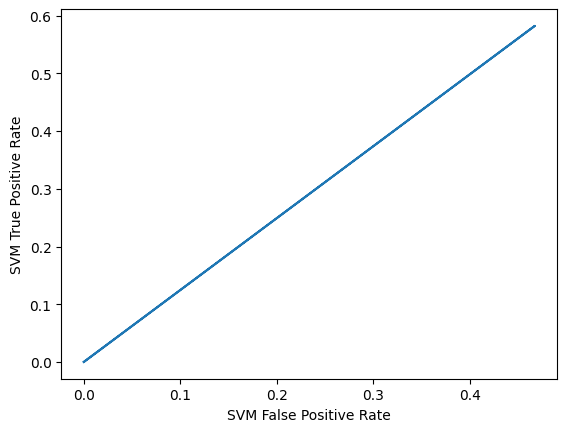

In [ ]:
svm_fpr, svm_tpr, svm_th = roc_curve(labels, pred)

plt.plot(svm_fpr, svm_tpr)
plt.xlabel('SVM False Positive Rate')
plt.ylabel('SVM True Positive Rate')
plt.show()

In [ ]:
## For the Test Set ##
x_test_data = X_test.to_numpy()

score = x_test_data @ w
x_test_pred = np.sign(score - b).astype(int)
labels_y_test = y_test.to_numpy()

In [ ]:
## For the Test Set ##
print("Confusion matrix:", confusion_matrix(labels_y_test, x_test_pred), sep='\n')
print("F1 score:", f1_score(labels_y_test, x_test_pred, average='weighted'))
print("Jaccard score (IoU):", jaccard_score(labels_y_test, x_test_pred, average='weighted'))

Confusion matrix:
[[  0   0   0]
 [435   0 345]
 [388   0 457]]
F1 score: 0.2885731633272617
Jaccard score (IoU): 0.19969747899159665


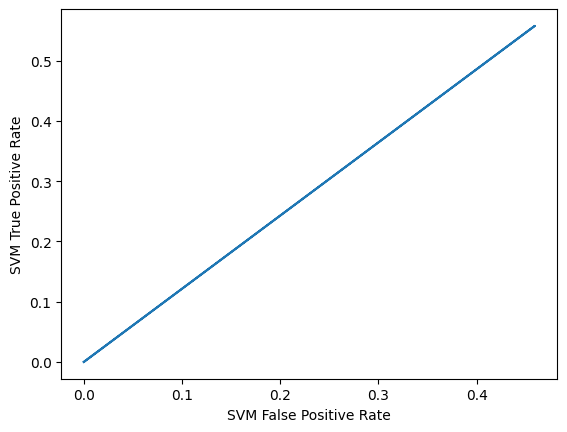

In [ ]:
svm_fpr, svm_tpr, svm_th = roc_curve(labels_y_test, x_test_pred)

plt.plot(svm_fpr, svm_tpr)
plt.xlabel('SVM False Positive Rate')
plt.ylabel('SVM True Positive Rate')
plt.show()

## Simple Car Environment
---

![simple_car.gif](https://media0.giphy.com/media/v1.Y2lkPTc5MGI3NjExODU0NmVlMzU1MGU1YzJjMjA5ODE5NjM0MTg0MTU1ZmM1OTA1NzRkNCZjdD1n/VI3OuvQShK3gzENiVz/giphy.gif)

*(code for this tutorial adapted from: https://gerardmaggiolino.medium.com/creating-openai-gym-environments-with-pybullet-part-2-a1441b9a4d8e*)

---

This is a simple car environment with a continuous state space and discrete action space with the goal of driving towards a green marker. Driving within 1.5 metres of the green marker causes the episode to end or if a certain amount of time has passed.

We can instantiate the environment as follows:


```
env = gym.make('SimpleDriving-v0', apply_api_compatibility=True, renders=False, isDiscrete=True, render_mode='tp_camera')
```


### Action Space

*   0: Reverse-Left
*   1: Reverse
*   2: Reverse-Right
*   3: Steer-Left (no throttle)
*   4: No throttle and no steering
*   5: Steer-Right (no throttle)
*   6: Forward-right
*   7: Forward
*   8: Forward-left


Before we can execute any code we first need to install the following packages:

In [1]:
## Running this on Ubuntu so installed locally. No need to run this code block.
## Note issue of asking for password anyway so running this in code block doesnt work.
# !pip install gym==0.26.2 pyvirtualdisplay pygame torch > /dev/null 2>&1
# !pip install git+https://github.com/fredsukkar/simple-car-env-template > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# !apt-get install -y xvfb

Now import the necessary packages and following helper functions (you don't need the `display_video` function if running locally):

In [2]:
import os
os.environ['PYVIRTUALDISPLAY_DISPLAYFD'] = '0'

import gym
import simple_driving
# import pybullet_envs
import pybullet as p
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import math
from collections import defaultdict
import pickle
from IPython.display import clear_output
import torch
import random

display = Display(visible=0, size=(400, 300))
display.start()

def display_video(frames, framerate=30):
  """Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  
  #ipythondisplay.display(HTML(anim.to_html5_video()))
  return HTML(anim.to_html5_video())

pybullet build time: Nov 28 2023 23:51:11


In [3]:
######################### renders image from third person perspective for validating policy ##############################
env = gym.make("SimpleDriving-v0", apply_api_compatibility=True, renders=False, isDiscrete=True, render_mode='tp_camera')
##########################################################################################################################

######################### renders image from onboard camera ###############################################################
# env = gym.make("SimpleDriving-v0", apply_api_compatibility=True, renders=False, isDiscrete=True, render_mode='fp_camera')
##########################################################################################################################

######################### if running locally you can just render the environment in pybullet's GUI #######################
# env = gym.make("SimpleDriving-v0", apply_api_compatibility=True, renders=True, isDiscrete=True)
##########################################################################################################################

state, info = env.reset()
frames = []
frames.append(env.render())

for i in range(200):
    action = env.action_space.sample()
    state, reward, done, _, info = env.step(action)
    frames.append(env.render())  # if running locally not necessary unless you want to grab onboard camera image
    if done:
        break

env.close()
display_video(frames, framerate=5)  # remove if runnning locally

A random mushroom has been spawned. Robot will investigate.
Is the random mushroom edible?:  True
argv[0]=
argv[0]=
A random mushroom has been spawned. Robot will investigate.
Is the random mushroom edible?:  True
argv[0]=
argv[0]=


/home/student/.local/lib/python3.8/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(
/home/student/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/student/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
/home/student/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/student/.local/lib/python3.8/site-package

Sticking close to mushroom
Sticking close to mushroom


Here is some code to help you get started.

In [4]:
# Helper function to discretize state
def discretize_state(state):
    return tuple(int(np.digitize(s, bins)) for s, bins in zip(state, state_bins))

# Epsilon-greedy function
def epsilon_greedy(state, exploration_rate):
    if state not in q_table:
        q_table[state] = {a: 0 for a in range(env.action_space.n)}
    
    if np.random.rand() < exploration_rate:
        # action_probs = [0.7, 0.05, 0.05, 0.05, 0.03, 0.03, 0.03, 0.03, 0.03]
        action_probs = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.1, 0.5, 0.1]
        action = np.random.choice(range(env.action_space.n), p=action_probs)
    else:
        action = max(q_table[state], key=q_table[state].get)
    
    return action

# Q-learning function
def q_learning(state, action, reward, next_state):
    if state not in q_table:
        q_table[state] = {a: 0 for a in range(env.action_space.n)}
    
    old_q_value = q_table[state][action]
    next_max = max(q_table[next_state].values()) if next_state in q_table else 0
    new_q_value = (1 - learning_rate) * old_q_value + learning_rate * (reward + discount_factor * next_max)
    q_table[state][action] = new_q_value

In [5]:
# TRAINING MODEL
# Define Learning parameters
learning_rate = 0.3  # learning rate (0.1 - 0.3)
discount_factor = 0.95  # Future gains (0.90 - 0.99)
exploration_rate = 1.0  # Initial exploration rate (Always 1.0)
exploration_decay = 0.98  # Decrease exploration factor over time (0.95 - 0.99)
num_episodes = 400  # If the problem is complex, we should train for longer.

# Create environment
env = gym.make("SimpleDriving-v0", apply_api_compatibility=True, renders=False, isDiscrete=True, render_mode='tp_camera')

# Define state discretization parameters
num_bins = 10
state_bins = [np.linspace(env.observation_space.low[i], env.observation_space.high[i], num_bins - 1) for i in range(len(env.observation_space.low))]

# Initialize Q-table as a nested dictionary
q_table = {}

# Training loop
print(f"Training has started.")
for episode in range(num_episodes):
    state, _ = env.reset()
    state = discretize_state(state)
    done = False
    total_reward = 0    
    while not done:
        action = epsilon_greedy(state, exploration_rate)
        next_state, reward, done, _, info = env.step(action)
        next_state = discretize_state(next_state)
        q_learning(state, action, reward, next_state)
        
        state = next_state
        total_reward += reward
    
    exploration_rate *= exploration_decay
    
    # Print episode details if needed
    print(f"Training Episode: {episode + 1}, Total Reward: {total_reward}, Exploration Rate: {exploration_rate}")
print(f"Training complete.")


/home/student/.local/lib/python3.8/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(
/home/student/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/student/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/student/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:137: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(
/home/student/.local/lib/python3.8/site-packages/gym/spaces/box.py:227: UserWarning: WARN: Casting i

A random mushroom has been spawned. Robot will investigate.
Is the random mushroom edible?:  True
argv[0]=
argv[0]=
Training has started.
REACHED GOAL
Training Episode: 1, Total Reward: -110.88731929786071, Exploration Rate: 0.98
Training Episode: 2, Total Reward: -533.5277793409285, Exploration Rate: 0.9603999999999999
Training Episode: 3, Total Reward: -238.55902813293906, Exploration Rate: 0.9411919999999999
Training Episode: 4, Total Reward: -660.7854712007882, Exploration Rate: 0.9223681599999999
Training Episode: 5, Total Reward: -589.6332521364552, Exploration Rate: 0.9039207967999998
Training Episode: 6, Total Reward: -405.4682133416175, Exploration Rate: 0.8858423808639998
Training Episode: 7, Total Reward: -422.6031939043999, Exploration Rate: 0.8681255332467198
Training Episode: 8, Total Reward: -639.0112967304309, Exploration Rate: 0.8507630225817854
Training Episode: 9, Total Reward: -362.6626569882293, Exploration Rate: 0.8337477621301497
Training Episode: 10, Total Rewar

In [6]:
### TEST LEARNT POLICY
# Create environment
env = gym.make("SimpleDriving-v0", apply_api_compatibility=True, renders=False, isDiscrete=True, render_mode='tp_camera')

print(f"Begin testing.")
frames = []  # For video
state, _ = env.reset()
state = discretize_state(state)
done = False
total_reward = 0

while not done:
    action = max(q_table[state], key=q_table[state].get)
    next_state, reward, done, _, info = env.step(action)
    state = discretize_state(next_state)
    total_reward += reward
    # Capture all episodes
    frames.append(env.render())
print(f"Total reward: {total_reward}")

# Close environment
env.close()
print(f"Test complete.")

# Display the video after training
display_video(frames, framerate=8)

A random mushroom has been spawned. Robot will investigate.
Is the random mushroom edible?:  True
argv[0]=
argv[0]=
Begin testing.


/home/student/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


Total reward: -301.6564961655914
Test complete.
